# Havana Take Home Test Planning
In this notebook, I will go through the following steps:
1. Conduct EDA on the dataset (aim for 40 minutes)
2. Using the EDA, plan how we can improve the system (aim for 20 minutes)

## Assumptions
- I assume that the human labels are the ground truth, although I know I am supposed to take it as a starting point and not necessarily the ground truth. Suppose I join the company and upon discussion and to our horror, the human labels only have 70% accuracy. Then it is paramount that we create accurate human ground truth before we proceed with all the steps below. 
- And in the event that human labels have low accuracy, I will suggest picking 50-100 rows of data and manually label them (that will be me doing the job- not enjoyable but essential grunt work). Then we can proceed with the steps that I have outlined.
- Since the transcript in the dataset seems to be truncated, I will not proceed with this grounding of human labels.

## EDA
1. Given that the transcript is often short, I assume that most of the conversation data is missing from this dataset for privacy reasons. As such, I will be putting aside analysing the `transcript` column for speed reasons.
2. `time_zone` could be interesting, given that it could be a strong factor to misclassifications. I will put this in the back of my mind and see if we have time to further analyse this feature.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,id,transcript,timestamp,time_zone,human_generated_intent,human_generated_intent_time,predicted_intent,predicted_interested_time,predicted_callback_time,Unnamed: 9,comments
0,1,User: Hello?\nAgent: Hi \nUser: Hello? \nAgent...,2025-03-30T11:00:00,Asia/Singapore,voice_wants_call_back,2026-01-01T09:00:00,voice_not_interested,NaN,NaN,NaN,1. find out the mismatch between human and ai ...
1,2,User: Hello?\nAgent: Hi \nUser: Hello? \nAgent...,2025-03-30T11:00:00,Asia/Singapore,voice_wants_call_back,2025-03-31T09:00:00,voice_wants_call_back,NaN,2025-03-31T18:00:00,NaN,2. do I need to review intent time as well?
2,3,User: Big o mum. Is mid\nAgent: Hi there! This...,2025-04-26T12:23:16,Europe/London,voice_wants_call_back,2025-04-26T15:00:00,voice_wants_call_back,NaN,2025-04-26T15:00:00,NaN,3. put in eval faq with this csv and ask claud...
3,4,"Agent: Hi John, I'm David, an AI calling from ...",2025-04-26T12:23:16,Europe/London,voice_wants_call_back,2026-01-01T09:00:00,voice_not_interested,NaN,NaN,NaN,"4. for cases with high accuracy, simply automate"
4,5,"User: Hello?\nAgent: Hi Xavier, this is James ...",2025-06-07T10:24:15,Asia/Singapore,voice_wants_call_back,2025-06-07T12:00:00,voice_wants_call_back,NaN,2025-06-07T15:00:00,NaN,NaN


In [3]:
# drop id column as it is not useful
df = df.drop(columns=["id"])


### Bar chart breakdown
The purpose is to give us an intuition of what should be done.

In [4]:
human_counts = df["human_generated_intent"].value_counts()
pred_counts = df["predicted_intent"].value_counts()

all_labels = sorted(set(df["human_generated_intent"]).union(df["predicted_intent"]))

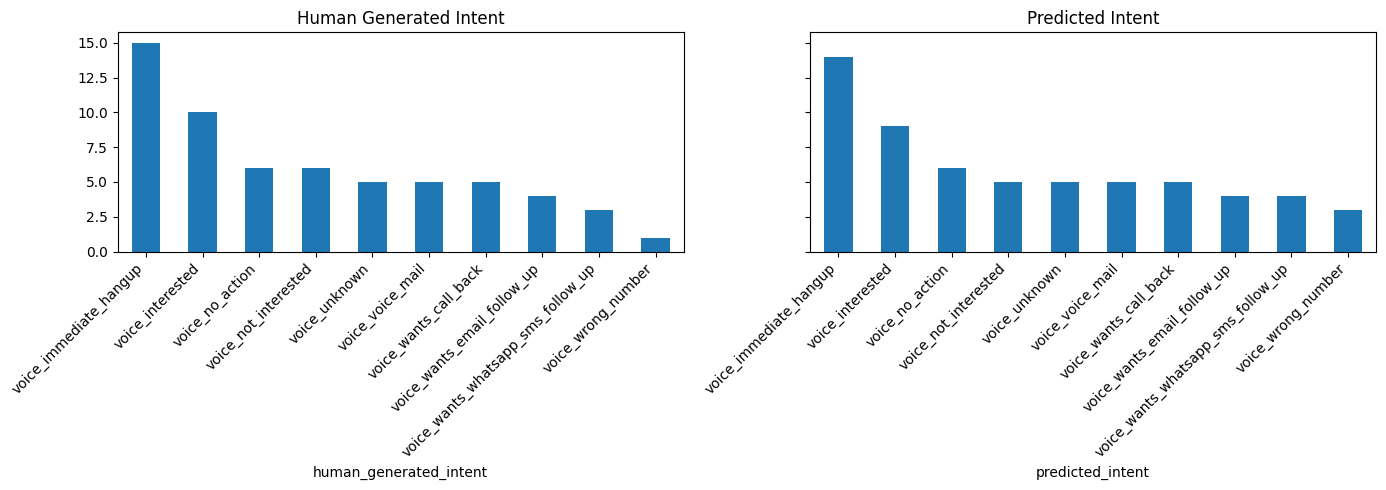

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

human_counts.plot(kind="bar", ax=axes[0], title="Human Generated Intent")
pred_counts.plot(kind="bar", ax=axes[1], title="Predicted Intent")

for ax in axes:
    ax.set_xticklabels(all_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()

On first inspection, there is slight differences in the distribution, but the shape of the distribution across both plots is largely similar. A quick sanity check on this plot also indicates that the labels make sense- e.g. most people would hang up immediately.

### Misclassification analysis
The next step is probably the most important- if we get a sense of the common fail points, then we can:
1. work on these fail points, either by adopting prompt engineering (few shot prompting) or improving quality of data (e.g. is the labelling failing because the audio quality sucks?)
2. create heuristics for our current workflow such that we can (a) automate some labels since we have high confidence in their accuracy and (b) include them in a test set to run regression testing as we update our classification in step 1

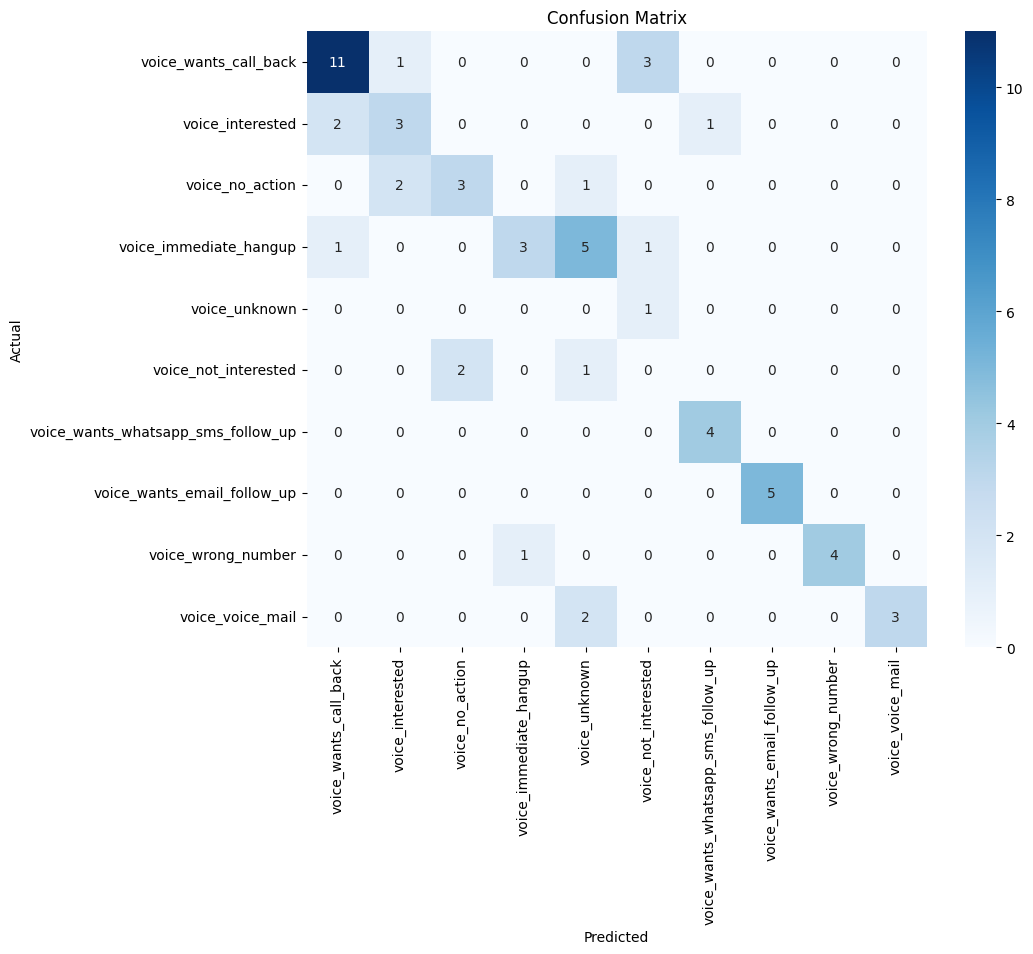

In [6]:
cm = confusion_matrix(df["human_generated_intent"], df["predicted_intent"], labels=df["human_generated_intent"].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=df["human_generated_intent"].unique(), 
            yticklabels=df["human_generated_intent"].unique(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

On first inspection, this classification matrix actually provides us with good news! Our human labels and predicted labels largely agree with each other, especially on the features that are important:
- all the `voice_wants`
- `voice_interested`

My next inspection involves the misclassification, specifically assuming positive intent when the user wants negative intent and vice versa. To do so, I map each type of intent to a binary class `interested` or `not_interested`. My main goal of doing this is to evaluate:
1. any missed opportunities to close (loss of revenue)
2. any potential for Havana to get the bad rep as the buggy and stupid AI slop

In [7]:
intent_mapping = {
    "voice_interested": "interested",
    "voice_wants_call_back": "interested",
    "voice_wants_email_follow_up": "interested",
    "voice_wants_whatsapp_sms_follow_up": "interested",
    "voice_no_action": "interested",
    
    "voice_not_interested": "not_interested",
    "voice_immediate_hangup": "not_interested",
    "voice_wrong_number": "not_interested",
    "voice_voice_mail": "not_interested",
    "voice_unknown": "not_interested",
}

In [8]:
df["human_bucket"] = df["human_generated_intent"].map(intent_mapping)
df["pred_bucket"] = df["predicted_intent"].map(intent_mapping)

In [9]:
cm = confusion_matrix(df["human_bucket"], df["pred_bucket"], labels=["interested", "not_interested"])

In [10]:
cm_df = pd.DataFrame(cm,
                     index=["Actual_Interested", "Actual_NotInterested"],
                     columns=["Pred_Interested", "Pred_NotInterested"])

print(cm_df)

                      Pred_Interested  Pred_NotInterested
Actual_Interested                  32                   4
Actual_NotInterested                3                  21


Quick analysis- we have high accuracy:
- (32+21)/(32+4+3+21) = 53/60 ≈ 88%

Given that the number of misclassified category is almost the same, I propose we target the misclassification of `Actual_Interested` as `Pred_NotInterested`.

In [11]:
misclassified = df[df["human_bucket"] != df["pred_bucket"]]

mis_summary = misclassified.value_counts(["human_generated_intent", "predicted_intent"]).reset_index(name="count")

print(mis_summary.sort_values("count", ascending=False))


   human_generated_intent       predicted_intent  count
0   voice_wants_call_back   voice_not_interested      3
1    voice_not_interested        voice_no_action      2
2  voice_immediate_hangup  voice_wants_call_back      1
3         voice_no_action          voice_unknown      1


The pair of `voice_not_interested` and `voice_no_action` seems ok, as we will not be proceeding with any next step either case.

The pair of `voice_wants_call_back` and `voice_not_interested` is problematic though- it's our top contributor and indicates potential lost revenue- 3/60 = 5% of our dataset, that's significant. Especially if we can improve on this, then it shows Havana's efficacy and we can charge more.

### High confidence classification
Now that we have spotted the fail cases, let's look at the positive cases where we can reduce the manual review.

In [12]:
per_intent_accuracy = (
    (df["human_generated_intent"] == df["predicted_intent"])
    .groupby(df["human_generated_intent"])
    .mean()
    .reset_index(name="accuracy")
)

In [13]:
counts = df["human_generated_intent"].value_counts().reset_index()
counts.columns = ["human_generated_intent", "support"]

In [14]:
intent_stats = per_intent_accuracy.merge(counts, on="human_generated_intent")

In [15]:
total_rows = len(df)
intent_stats["support_pct"] = intent_stats["support"] / total_rows
intent_stats = intent_stats.sort_values("accuracy", ascending=False)
print(intent_stats)

               human_generated_intent  accuracy  support  support_pct
7         voice_wants_email_follow_up  1.000000        5     0.083333
8  voice_wants_whatsapp_sms_follow_up  1.000000        4     0.066667
9                  voice_wrong_number  0.800000        5     0.083333
6               voice_wants_call_back  0.733333       15     0.250000
5                    voice_voice_mail  0.600000        5     0.083333
1                    voice_interested  0.500000        6     0.100000
2                     voice_no_action  0.500000        6     0.100000
0              voice_immediate_hangup  0.300000       10     0.166667
3                voice_not_interested  0.000000        3     0.050000
4                       voice_unknown  0.000000        1     0.016667


We see that there are 3 intents where the accuracy is at least 80%. I propose that we automate these three intents to proceed with the next step, and leave the remaining for manual review/approval.

## Plan for intent classification
### Improving our classification
1. Work on reducing the misclassification between `voice_wants_call_back` and `voice_not_interested`. In practice I have to dig into the data and find out why there is a misclassification. Assuming that human labels are accurate, I will consider other approaches like prompt engineering (using few shot prompting), inspecting audio quality etc.
2. Focus on improving `voice_wants_call_back`, `voice_voice_mail` and `voice_interested` classifications- these are the classifications that have lower accuracy but still decent support. In addition, these classifications can bring in more revenue.
3. Collect and clean more data for `voice_interested`, `voice_no_action` and `voice_immediate_hangup` since these are high frequency but low accuracy.

### Reducing manual review
1. Automate `voice_wants_email_follow_up`, `voice_wants_whatsapp_sms_follow_up`, `voice_wrong_number`- these are high accuracy. In addition, add these cases into our regression test set so that we can run regression testing as we improve the classification.
2. For `voice_wants_call_back` and `voice_voice_mail`, get model to output classification and confidence level so that human can manually review and decide. The aim of the confidence level is to help humans reduce their cognitive load in making decisions.

## Intent time
Next up, we will proceed with analysing intent time. We will filter to get rows where human_generated_intent matches predicted_intent.

In [16]:
correct_preds = df[df["human_generated_intent"] == df["predicted_intent"]].copy()

In [17]:
def get_predicted_time(row):
    if row["predicted_intent"] == "voice_interested":
        return row["predicted_interested_time"]
    elif row["predicted_intent"] == "voice_wants_call_back":
        return row["predicted_callback_time"]
    else:
        return pd.NaT

In [18]:
correct_preds["predicted_time"] = correct_preds.apply(get_predicted_time, axis=1)

In [19]:
correct_preds.head()

,transcript,timestamp,time_zone,human_generated_intent,human_generated_intent_time,predicted_intent,predicted_interested_time,predicted_callback_time,Unnamed: 9,comments,human_bucket,pred_bucket,predicted_time
1,User: Hello?\nAgent: Hi \nUser: Hello? \nAgent...,2025-03-30T11:00:00,Asia/Singapore,voice_wants_call_back,2025-03-31T09:00:00,voice_wants_call_back,NaN,2025-03-31T18:00:00,NaN,2. do I need to review intent time as well?,interested,interested,2025-03-31T18:00:00
2,User: Big o mum. Is mid\nAgent: Hi there! This...,2025-04-26T12:23:16,Europe/London,voice_wants_call_back,2025-04-26T15:00:00,voice_wants_call_back,NaN,2025-04-26T15:00:00,NaN,3. put in eval faq with this csv and ask claud...,interested,interested,2025-04-26T15:00:00
4,"User: Hello?\nAgent: Hi Xavier, this is James ...",2025-06-07T10:24:15,Asia/Singapore,voice_wants_call_back,2025-06-07T12:00:00,voice_wants_call_back,NaN,2025-06-07T15:00:00,NaN,NaN,interested,interested,2025-06-07T15:00:00
5,"User: Hello?\nAgent: Hi Alan, this is James fr...",2025-06-08T10:24:15,Asia/Singapore,voice_wants_call_back,2025-06-08T14:00:00,voice_wants_call_back,NaN,2025-06-08T14:00:00,NaN,NaN,interested,interested,2025-06-08T14:00:00
6,User: Hello?\nAgent: Hi Joel! This is James fr...,2025-06-10T09:02:00,Asia/Singapore,voice_wants_call_back,2025-06-12T09:00:00,voice_wants_call_back,NaN,2025-06-12T09:00:00,NaN,NaN,interested,interested,2025-06-12T09:00:00


In [20]:
correct_preds["human_generated_intent_time"] = pd.to_datetime(correct_preds["human_generated_intent_time"], errors="coerce")
correct_preds["predicted_time"] = pd.to_datetime(correct_preds["predicted_time"], errors="coerce")

correct_preds = correct_preds.dropna(subset=["predicted_time", "human_generated_intent_time"])

In [21]:
# calculate time difference in minutes
correct_preds["time_diff_minutes"] = (correct_preds["predicted_time"] - correct_preds["human_generated_intent_time"]).dt.total_seconds() / 60.0
correct_preds["abs_time_diff_minutes"] = correct_preds["time_diff_minutes"].abs()

In [22]:
time_error_stats = correct_preds.groupby("predicted_intent")["abs_time_diff_minutes"].agg(["count", "mean", "median", "max"]).reset_index()
print(time_error_stats)

        predicted_intent  count          mean  median       max
0       voice_interested      2      0.000000     0.0       0.0
1  voice_wants_call_back     11  46904.742424   180.0  477540.0


Huge disparity in 'voice_wants_call_back'. Let's investigate this.

In [23]:
callback_rows = df[
    (df["human_generated_intent"] == "voice_wants_call_back") &
    (df["predicted_intent"] == "voice_wants_call_back")
].copy()

callback_rows.reset_index(drop=True, inplace=True)

In [24]:
callback_rows[['human_generated_intent_time', 'predicted_callback_time']]

,human_generated_intent_time,predicted_callback_time
0,2025-03-31T09:00:00,2025-03-31T18:00:00
1,2025-04-26T15:00:00,2025-04-26T15:00:00
2,2025-06-07T12:00:00,2025-06-07T15:00:00
3,2025-06-08T14:00:00,2025-06-08T14:00:00
4,2025-06-12T09:00:00,2025-06-12T09:00:00
5,2025-06-16T14:00:00,2025-06-16T18:00:00
6,2025-03-01T09:00:00,2025-03-03T18:00:00
7,2026-06-01T09:00:00,2025-07-04T18:00:00
8,2025-07-01T09:00:00,2025-06-07T18:00:00
9,2025-02-17T11:00:00,2025-02-17T11:12:10


In [25]:
mismatch_rows = callback_rows[callback_rows["human_generated_intent_time"] != callback_rows["predicted_callback_time"]].copy()

In [26]:
mismatch_rows[['time_zone', 'human_generated_intent_time', 'predicted_callback_time']]

,time_zone,human_generated_intent_time,predicted_callback_time
0,Asia/Singapore,2025-03-31T09:00:00,2025-03-31T18:00:00
2,Asia/Singapore,2025-06-07T12:00:00,2025-06-07T15:00:00
5,Asia/Singapore,2025-06-16T14:00:00,2025-06-16T18:00:00
6,Asia/Singapore,2025-03-01T09:00:00,2025-03-03T18:00:00
7,Asia/Singapore,2026-06-01T09:00:00,2025-07-04T18:00:00
8,Asia/Singapore,2025-07-01T09:00:00,2025-06-07T18:00:00
9,Asia/Singapore,2025-02-17T11:00:00,2025-02-17T11:12:10


Most of the time zones listed here are from Asia/Singapore- could this be the reason why there is a significant difference between the human generated and predicted time?

In [27]:
match_rows = callback_rows[callback_rows["human_generated_intent_time"] == callback_rows["predicted_callback_time"]].copy()

In [28]:
match_rows[['time_zone', 'human_generated_intent_time', 'predicted_callback_time']]

,time_zone,human_generated_intent_time,predicted_callback_time
1,Europe/London,2025-04-26T15:00:00,2025-04-26T15:00:00
3,Asia/Singapore,2025-06-08T14:00:00,2025-06-08T14:00:00
4,Asia/Singapore,2025-06-12T09:00:00,2025-06-12T09:00:00
10,Asia/Singapore,2024-11-28T19:00:00,2024-11-28T19:00:00


My initial hypothesis was that time_zone could be an issue why the human label and predicted time are so different. However, this is not the case. More worrisome, the time delta between human labelled and predicted are quite big- some even go up to a few days.

### Some hypothesis and improvement strategies
1. We see some time deltas of a few hours- this could be due to time zone differences across states. Do we account for this in our system?
2. For a few minutes differences, this could be an error in the transcription. While tricky, I have spotted only one case of this. In addition, it was a 12 minutes difference, so this may not be the highest priority to work on.
3. **My biggest concern is the difference in days**- I'm not sure why this is the issue, but it could be an error in transcription/poor audio quality. I propose that we add a rule-based heuristic to flag a case when the predicted_callback_time is more than a week from the contact date so that we can involve manual review for such cases.

## Some final thoughts
I spent 1.75 hours on this section- while I exceeded the suggested time by 75%, I believe this is the right approach given that we have to dig deeply into the data to understand what are the root causes.

Also note that I did not sketch out a timeline on how to implement the changes that I've suggested. My main concern is the data inspection/quality part, which could vary widely.

My rough plan will include:
1. Review human labels to ensure that they are accurate- time consuming, but essential.
2. Reduce manual review by automating classifications of `voice_wants_email_follow_up`, `voice_wants_whatsapp_sms_follow_up`, `voice_wrong_number`. Given that these are asynchronous follow up methods, we can automate the next step. In addition, we add examples of these classifications for regression testing.
3. Work on reducing the misclassification between `voice_wants_call_back` and `voice_not_interested`. This could be due to audio quality, or we may need better prompt engineering.
4. Dig into the cause of hours difference- I note that we do handle the timezones of the students. Check if this is accurate- did we explicitly ask them which state they will be in? Else it could be an issue of audio quality- I'm most worried about the hours difference, since minutes difference is tolerable and we can flag days difference (when a predicted call is at least a week away from the last contact).